In [1]:
import pandas as pd
import numpy as np

from google.colab import files


uploaded = files.upload()

Saving insurance_data.csv to insurance_data.csv


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
import pickle

In [2]:
data = pd.read_csv('insurance_data.csv')

data.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


In [5]:
data.drop(columns=['index','PatientID'],inplace=True)
data.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [6]:
data.shape

(1340, 9)

In [7]:
#How Many Null Values
data.isnull().sum()

,0
age,5
gender,0
bmi,0
bloodpressure,0
diabetic,0
children,0
smoker,0
region,3
claim,0


In [8]:
df = data.dropna()

In [10]:
for col in cat_cols:
    df.loc[:, col] = df[col].str.strip().str.lower()

In [11]:
df = df.reset_index(drop=True)

In [14]:
print(df.shape)
print(df.isnull().sum())
df.head()

(1332, 9)
age              0
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           0
claim            0
dtype: int64


,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,23.2,91,yes,0,no,southeast,1121.87
1,24.0,male,30.1,87,no,0,no,southeast,1131.51
2,19.0,male,41.1,100,no,0,no,northwest,1146.80
3,20.0,male,43.0,86,no,0,no,northwest,1149.40
4,30.0,male,53.1,97,no,0,no,northwest,1163.46


# **Exploratory Data Analysis**

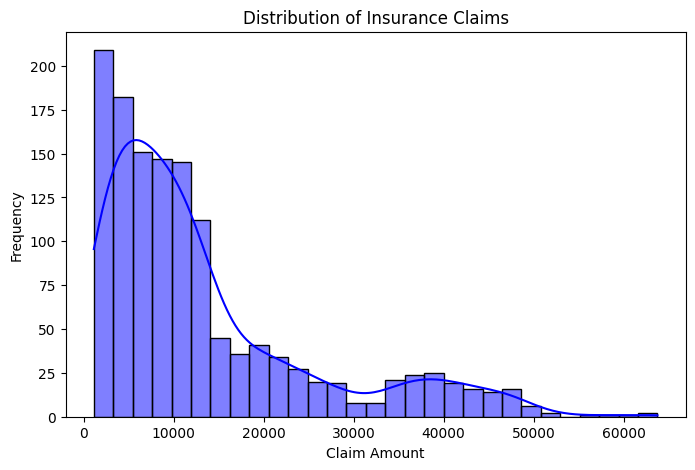

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df['claim'], kde=True, color='blue')
plt.title('Distribution of Insurance Claims')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.show()

Most claims are low to moderate, but a few customers submit very high claims.

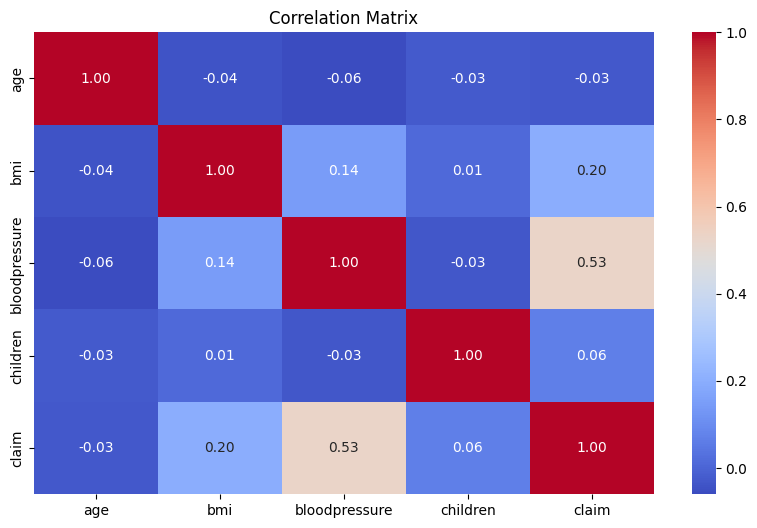

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

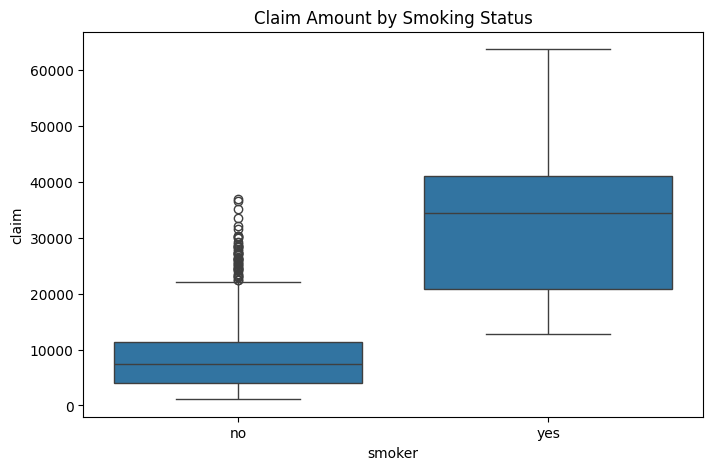

In [19]:
#Smoker vs Claim
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='smoker', y='claim')
plt.title('Claim Amount by Smoking Status')
plt.show()

Smokers tend to have much higher claim amounts.

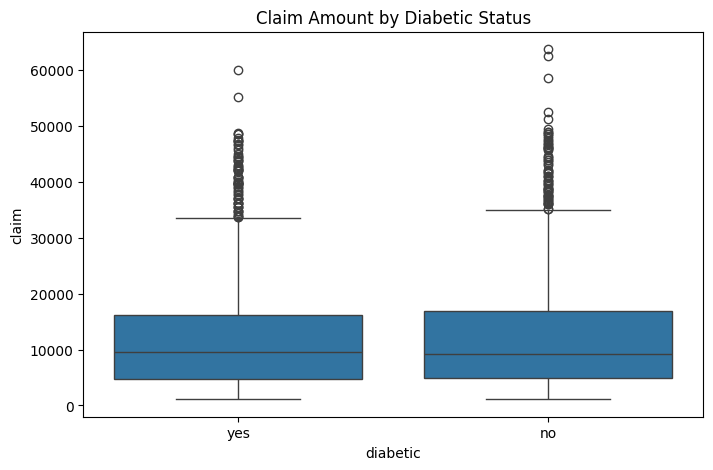

In [22]:
#Diabetic vs Claim
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='diabetic', y='claim')
plt.title('Claim Amount by Diabetic Status')
plt.show()

Diabetic customers have slightly higher claims, but the spread is not as extreme as smokers.

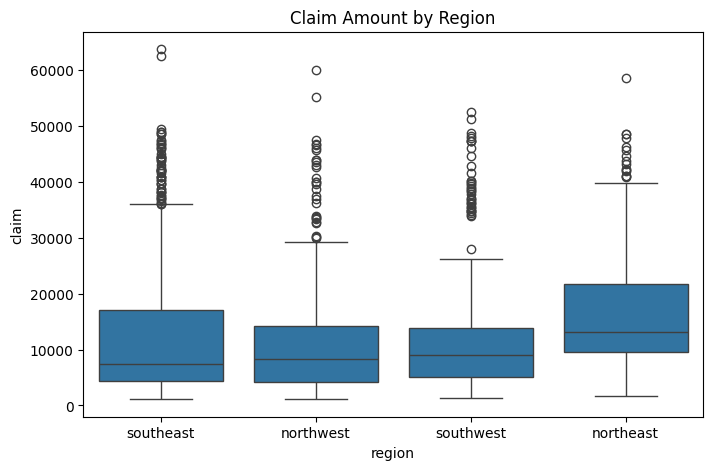

In [23]:
#Region vs Claim
plt.figure(figsize=(8,5))
sns.boxplot(data=df,x='region',y='claim')
plt.title('Claim Amount by Region')
plt.show()

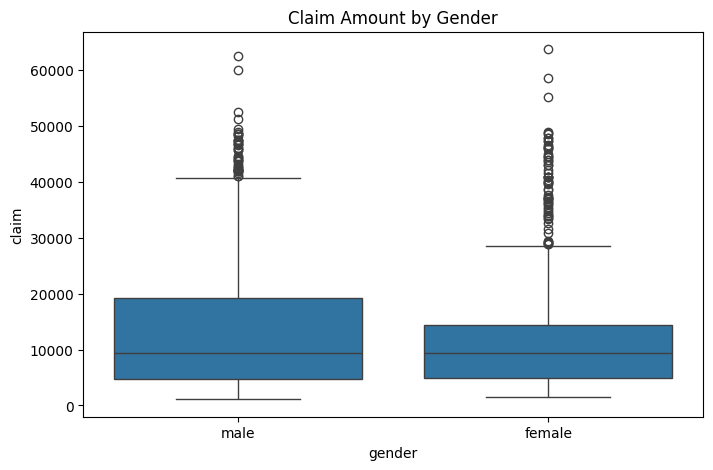

In [24]:
#Gender vs Claim
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='gender', y='claim')
plt.title('Claim Amount by Gender')
plt.show()

Little difference in claim amounts between genders.
Gender may not be a strong predictor.

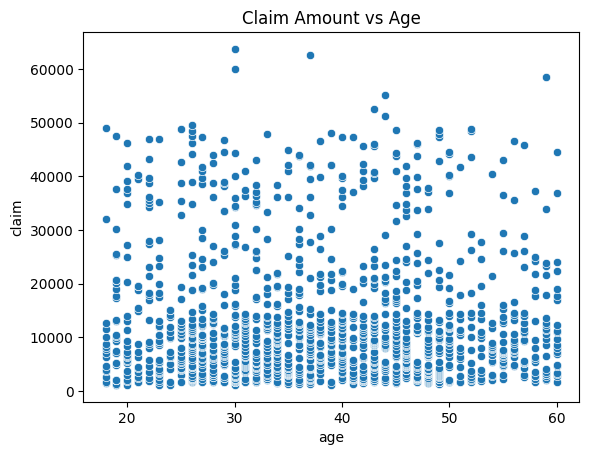

In [25]:
#Age vs Claim
sns.scatterplot(data=df, x='age', y='claim')
plt.title('Claim Amount vs Age')
plt.show()

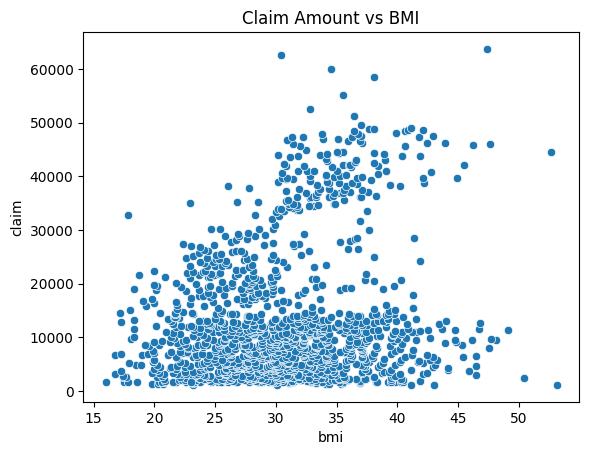

In [26]:
#BMI vs Claim
sns.scatterplot(data=df, x='bmi', y='claim')
plt.title('Claim Amount vs BMI')
plt.show()

# **Train Model**

In [27]:
df_encoded = pd.get_dummies(df, columns=['gender', 'diabetic', 'smoker', 'region'], drop_first=True)

In [28]:
X = df_encoded.drop('claim', axis=1)
y = df_encoded['claim']

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

In [32]:
#Train Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

In [35]:
def evaluate_model(y_true, y_pred, model_name):
    print(f" {model_name} Performance:")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("r2_score  :", r2_score(y_true, y_pred))
    print("-" * 40)

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")

 Linear Regression Performance:
MAE : 4910.906546802689
RMSE: 6234.640754772451
r2_score  : 0.730313099844894
----------------------------------------
 Random Forest Regressor Performance:
MAE : 3909.762390636704
RMSE: 5138.810626809965
r2_score  : 0.8167845007776601
----------------------------------------


Random Forest Regressor outperforms Linear Regression on all metrics.

It delivers:
Lower error MAE and Better fit r2_score

This model is better at capturing complex, non-linear relationships in the data.

We will use Random Forest for predicting insurance claim amounts going forward.

/tmp/ipython-input-2975398217.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


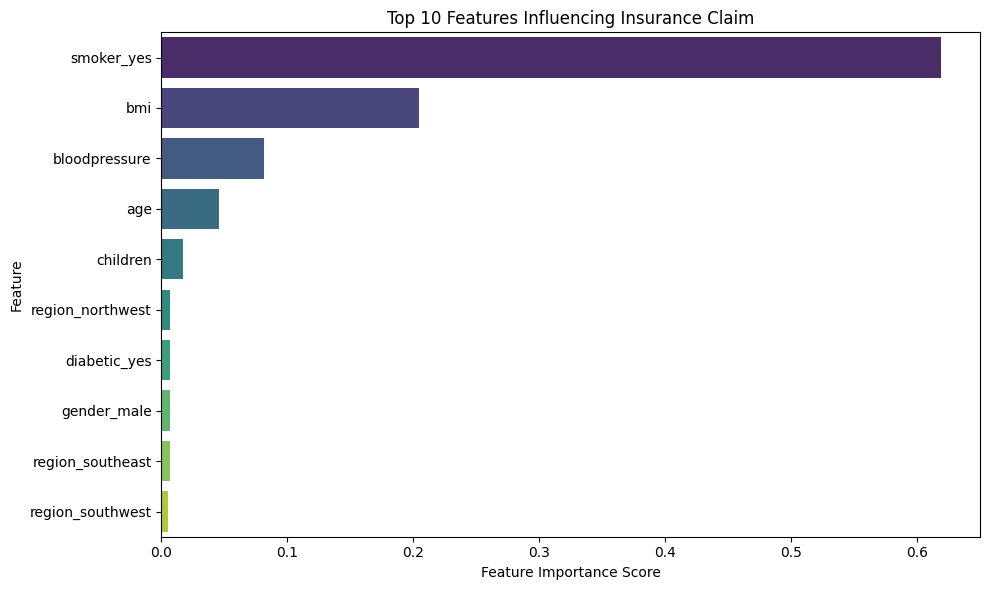

In [36]:
# Get feature importances
importances = rf_model.feature_importances_
features = X_train.columns

# Create DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features Influencing Insurance Claim')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [38]:
# Features to be used
categorical_cols = ['gender', 'diabetic', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'bloodpressure', 'children']

In [39]:
df_clean = df.dropna(subset=categorical_cols + numerical_cols + ['claim'])

# Features & Target
X = df_clean[categorical_cols + numerical_cols]
y = df_clean['claim']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# One-hot encoder for categorical variables
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer to handle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'diabetic',
                                                   'smoker', 'region']),
                                                 ('num', 'passthrough',
                                                  ['age', 'bmi',
                                                   'bloodpressure',
                                                   'children'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [43]:
y_pred = pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("r2_score :", r2_score(y_test, y_pred))

MAE: 3931.7744921348312
r2_score : 0.8150307354425401


In [44]:
joblib.dump(pipeline, 'claim_model.joblib')

['claim_model.joblib']

In [45]:
with open('claim_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)